# Verifying the SpeechT5 TTS model

I needed to do the following to be able to load the original model:

- Clone the https://github.com/microsoft/SpeechT5 repo

Install stuff:

```
pip install editdistance
pip install -U sacrebleu==1.5.1

git submodule update --init SpeechT5/fairseq
cd SpeechT5
pip install --editable fairseq/
pip install espnet
```

Hack the code:

- Copy `speecht5/tasks/speecht5.py` into `fairseq/fairseq/tasks`

- `checkpoint_utils.py`: comment out a bunch of the loading stuff because of missing keys in the checkpoint

Additional stuff to download:

- `dict.txt` from https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK

- `tokenizer` from https://drive.google.com/uc?export=download&id=1wClgQjXXoU2lmpbaEa1v2SqMbg7cAutq

- `xvectors.zip` from https://drive.google.com/uc?export=download&id=16QOUURZBrW7-GYbVG_gXt3mTMlZmQoH0

- everything from https://huggingface.co/mechanicalsea/speecht5-tts

- https://github.com/kan-bayashi/ParallelWaveGAN

In [1]:
%reload_ext autoreload
%autoreload 2

Set Python path so it can find the `speecht5` and `fairseq` modules.

In [2]:
import sys
sys.path.insert(0, "../SpeechT5/SpeechT5")
sys.path.insert(0, "../SpeechT5/SpeechT5/fairseq")

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Tokenize input text

In [4]:
# TODO: run the original tokenizer

In [5]:
# TODO: run our own tokenizer

In [6]:
src_tokens = torch.tensor([[
    4, 35,  5, 22, 23,  4, 20, 11,  7,  6, 31, 12,  4, 16, 24, 23,  4, 35,
         16, 21, 21, 10,  9, 21,  4, 55,  7, 17,  5, 41,  4, 32, 11, 10, 12,  4,
         10, 12,  4, 34, 24,  5,  5, 17, 11,  4,  6,  5,  5,  4, 19, 10, 27,  5,
          4,  6,  7, 15, 28, 10,  9, 21,  4,  6,  8,  4, 22,  8, 16,  4, 19,  8,
         13,  4, 13,  5,  7, 15, 26
]])

In [7]:
inputs = {
    "input_ids": src_tokens,
#    "attention_mask": torch.ones_like(src_tokens),
}

In [ ]:
# TODO: test with attention mask

In [8]:
# TODO: test batch!

## Load the Transformers model

To convert the original checkpoint weights to Transformers:

First download the checkpoint from https://huggingface.co/mechanicalsea/speecht5-tts

Then run the following, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task t2s \
  --checkpoint_path /path/to/SpeechT5/speecht5_tts.pt
  --pytorch_dump_folder_path /some/other/path
```

In [9]:
from transformers import (
    SpeechT5Config, 
    SpeechT5CTCTokenizer,
    SpeechT5Processor,
    SpeechT5Model, 
    SpeechT5ForConditionalGeneration, 
    SpeechT5ForCTC, 
    SpeechT5ForTTS,
    Wav2Vec2FeatureExtractor,
)

In [10]:
# config = SpeechT5Config()
# hf_model = SpeechT5Model(config)

In [11]:
model_checkpoint = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_tts.pt"

In [168]:
hf_model = SpeechT5ForTTS.from_pretrained(model_checkpoint)

In [169]:
hf_model.eval()

SpeechT5ForTTS(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithTextPrenet(
      (prenet): SpeechT5TextEncoderPrenet(
        (embed_tokens): Embedding(81, 768, padding_idx=1)
        (encode_positions): SpeechT5ScaledPositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (wrapped_encoder): SpeechT5Encoder(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layers): ModuleList(
          (0): SpeechT5EncoderLayer(
            (attention): SpeechT5Attention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
            (layer_nor

In [14]:
# Loading should work OK for class `SpeechT5Model` too:
hf_model_naked = SpeechT5Model.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at /Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_tts.pt were not used when initializing SpeechT5Model: ['speecht5.encoder.prenet.encode_positions.alpha', 'speecht5.encoder.prenet.encode_positions.pe', 'speecht5.encoder.prenet.embed_tokens.weight']
- This IS expected if you are initializing SpeechT5Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SpeechT5Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Load the original model

See the script `generate_speech.py` from the SpeechT5 repo.

Load the dictionary. This adds `<s>, <pad>, </s>, <unk>` tokens to the front and `<mask>` and `<ctc_blank>` to the end. **dict.txt** was [downloaded from here](https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK). This is the Vocabulary link from the main SpeechT5 README.

In [15]:
from fairseq.data import Dictionary
tgt_dict = Dictionary.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/DATA_ROOT/dict.txt")
tgt_dict.add_symbol("<mask>")
tgt_dict.add_symbol("<ctc_blank>")
print(f"dictionary size: " f"{len(tgt_dict):,}")

dictionary size: 81


To load the model we need the `SpeechT5Task` object but constructing it is annoying. Fortunately, `build_model` only reads two properties from the task object, so we can fake it.

In [16]:
class FakeTask:
    def __init__(self):
        self.dicts = { "text": tgt_dict }
        self.t5_task = "t2s"
        
task = FakeTask()

Load the fine-tuned ASR model.

In [17]:
import torch
from speecht5.models.speecht5 import T5TransformerModel

In [18]:
checkpoint = torch.load("../weights/speecht5-tts/speecht5_tts.pt")

orig_model = T5TransformerModel.build_model(checkpoint["cfg"]["model"], task)

orig_model.load_state_dict(checkpoint["model"])
orig_model = orig_model.eval()

In [19]:
type(orig_model)

speecht5.models.speecht5.T5TransformerModel

In [20]:
type(orig_model.encoder)

speecht5.models.modules.encoder.TransformerEncoder

In [21]:
#list(checkpoint["model"].keys())

In [22]:
from fairseq.data import encoders
from argparse import Namespace
tokenizer = encoders.build_bpe(
    Namespace(
        bpe='sentencepiece', 
        sentencepiece_model='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/MODEL_DIR/spm_char.model'
    )
)
type(tokenizer)

fairseq.data.encoders.sentencepiece_bpe.SentencepieceBPE

In [ ]:
# orig_model.decoder.layers[0].encoder_attn

## Verify text encoder prenet output

The `text_encoder_prenet` converts the input tokens into embeddings of shape `(batch, sequence_length, 768)`.

In [208]:
with torch.no_grad():
    encoder_input, encoder_padding_mask = orig_model.text_encoder_prenet(src_tokens)

In [209]:
encoder_input.shape, encoder_padding_mask.shape

(torch.Size([1, 79, 768]), torch.Size([1, 79]))

In [210]:
encoder_input

tensor([[[-0.0383,  0.0826,  0.0607,  ..., -0.0333, -0.1770,  0.0203],
         [ 0.0857,  0.0239,  0.2346,  ...,  0.1588,  0.0084,  0.0664],
         [ 0.0644,  0.0361,  0.2011,  ..., -0.0519, -0.1996,  0.0747],
         ...,
         [ 0.1361,  0.1569, -0.1022,  ...,  0.1605,  0.0147,  0.0804],
         [ 0.2444, -0.0554, -0.0303,  ...,  0.0666,  0.0143, -0.0211],
         [ 0.0408, -0.0834,  0.1128,  ...,  0.1641, -0.0404,  0.0649]]])

In [211]:
#encoder_padding_mask

Run Hugging Face model:

In [212]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.prenet(**inputs)

type(hf_outputs)

torch.Tensor

In [213]:
[x.shape for x in hf_outputs if hasattr(x, "shape")]

[torch.Size([79, 768])]

In [214]:
hf_outputs[0]

tensor([[-0.0383,  0.0826,  0.0607,  ..., -0.0333, -0.1770,  0.0203],
        [ 0.0857,  0.0239,  0.2346,  ...,  0.1588,  0.0084,  0.0664],
        [ 0.0644,  0.0361,  0.2011,  ..., -0.0519, -0.1996,  0.0747],
        ...,
        [ 0.1361,  0.1569, -0.1022,  ...,  0.1605,  0.0147,  0.0804],
        [ 0.2444, -0.0554, -0.0303,  ...,  0.0666,  0.0143, -0.0211],
        [ 0.0408, -0.0834,  0.1128,  ...,  0.1641, -0.0404,  0.0649]])

In [215]:
hf_encoder_input = hf_outputs

If the weights and model were converted correctly, this should report zero or a very small number:

In [216]:
torch.max(torch.abs(encoder_input - hf_outputs[0]))

tensor(0.)

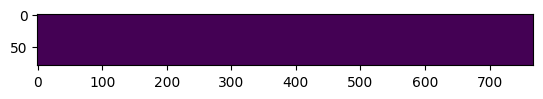

In [217]:
plt.imshow(torch.abs(encoder_input - hf_outputs[0]).numpy()[0] > 1e-5)

## Verify Transformer encoder output

In [218]:
# Run it with the original's speech prenet input:
with torch.no_grad():
    encoder_output = orig_model.encoder(encoder_input, encoder_padding_mask)

In [219]:
# # Run it with our input, which is slightly different (see above)
# with torch.no_grad():
#     encoder_output = orig_model.encoder(hf_encoder_input, ~hf_encoder_attention_mask)

In [220]:
print("encoder_out shape", encoder_output["encoder_out"][0].shape)
print("encoder_padding_mask shape", encoder_output["encoder_padding_mask"][0].shape)
print("encoder_states", encoder_output["encoder_states"])  # []
print("src_tokens", encoder_output["src_tokens"])  # []
print("decoder_input", encoder_output["decoder_input"])  # [None]
print("encoder_out_for_ctc shape", encoder_output["encoder_out_for_ctc"][0].shape)

encoder_out shape torch.Size([79, 1, 768])
encoder_padding_mask shape torch.Size([1, 79])
encoder_states []
src_tokens []
decoder_input [None]
encoder_out_for_ctc shape torch.Size([79, 1, 81])


In [221]:
encoder_output["encoder_out"][0].permute((1, 0, 2))

tensor([[[ 0.1216, -0.1223, -0.0161,  ...,  0.1346,  0.0016, -0.0969],
         [-0.4308,  0.2260,  0.2156,  ..., -0.1011,  0.0140, -0.4570],
         [-0.5038,  0.2883,  0.1684,  ...,  0.0300, -0.0678, -0.4736],
         ...,
         [ 0.4783, -0.1476, -0.0570,  ..., -0.2642, -0.6181,  0.2321],
         [ 0.4313, -0.2115, -0.1195,  ..., -0.4216, -0.4153,  0.2950],
         [ 0.0910, -0.0379,  0.1903,  ...,  0.0070, -0.1593, -0.0444]]])

In [222]:
encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2))

tensor([[[ 0.0323,  0.0410,  0.0620,  ...,  0.0133,  0.0218, -0.0187],
         [ 0.0523, -0.0873, -0.0304,  ..., -0.0184, -0.0473,  0.0077],
         [ 0.0937, -0.0637, -0.0121,  ..., -0.0029, -0.0065, -0.0139],
         ...,
         [-0.1147,  0.0520,  0.0286,  ...,  0.0440,  0.0449,  0.1282],
         [-0.1129,  0.0273, -0.0115,  ...,  0.0530,  0.0472,  0.1208],
         [ 0.0075, -0.0139,  0.0873,  ...,  0.0442, -0.0180, -0.0587]]])

In [223]:
# Use exact same inputs as the original model:
# with torch.no_grad():
#      hf_outputs = hf_model.speecht5(
#          inputs_embeds=encoder_input,
#          attention_mask=(~encoder_padding_mask),
#      )

# type(hf_outputs)

In [224]:
hf_encoder_input.shape

torch.Size([1, 79, 768])

In [225]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.wrapped_encoder(
         hidden_states=hf_encoder_input,
         attention_mask=torch.ones_like(src_tokens),
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutput

In [226]:
hf_outputs

BaseModelOutput(last_hidden_state=tensor([[[ 0.1216, -0.1223, -0.0161,  ...,  0.1346,  0.0016, -0.0969],
         [-0.4308,  0.2260,  0.2156,  ..., -0.1011,  0.0140, -0.4570],
         [-0.5038,  0.2883,  0.1684,  ...,  0.0300, -0.0678, -0.4736],
         ...,
         [ 0.4783, -0.1476, -0.0570,  ..., -0.2642, -0.6181,  0.2321],
         [ 0.4313, -0.2115, -0.1195,  ..., -0.4216, -0.4153,  0.2950],
         [ 0.0910, -0.0379,  0.1903,  ...,  0.0070, -0.1593, -0.0444]]]), hidden_states=None, attentions=None)

In [227]:
list(hf_outputs.keys())

['last_hidden_state']

In [228]:
hf_outputs["last_hidden_state"].shape

torch.Size([1, 79, 768])

In [229]:
hf_outputs["last_hidden_state"]

tensor([[[ 0.1216, -0.1223, -0.0161,  ...,  0.1346,  0.0016, -0.0969],
         [-0.4308,  0.2260,  0.2156,  ..., -0.1011,  0.0140, -0.4570],
         [-0.5038,  0.2883,  0.1684,  ...,  0.0300, -0.0678, -0.4736],
         ...,
         [ 0.4783, -0.1476, -0.0570,  ..., -0.2642, -0.6181,  0.2321],
         [ 0.4313, -0.2115, -0.1195,  ..., -0.4216, -0.4153,  0.2950],
         [ 0.0910, -0.0379,  0.1903,  ...,  0.0070, -0.1593, -0.0444]]])

In [230]:
torch.max(torch.abs(encoder_output["encoder_out"][0].permute((1, 0, 2)) - hf_outputs["last_hidden_state"]))

tensor(0.)

## Full encoder

In [259]:
inputs = src_tokens

In [274]:
# test batch
inputs = torch.tile(src_tokens, (2, 1))
inputs.shape

torch.Size([2, 79])

In [265]:
with torch.no_grad():
    encoder_out = orig_model.forward_text_encoder(inputs)

In [266]:
encoder_output["encoder_out"][0].permute((1, 0, 2))

tensor([[[ 0.1216, -0.1223, -0.0161,  ...,  0.1346,  0.0016, -0.0969],
         [-0.4308,  0.2260,  0.2156,  ..., -0.1011,  0.0140, -0.4570],
         [-0.5038,  0.2883,  0.1684,  ...,  0.0300, -0.0678, -0.4736],
         ...,
         [ 0.4783, -0.1476, -0.0570,  ..., -0.2642, -0.6181,  0.2321],
         [ 0.4313, -0.2115, -0.1195,  ..., -0.4216, -0.4153,  0.2950],
         [ 0.0910, -0.0379,  0.1903,  ...,  0.0070, -0.1593, -0.0444]]])

In [270]:
encoder_output["encoder_out"][0].permute((1, 0, 2)).shape

torch.Size([1, 79, 768])

In [273]:
# TODO: what happened to my batch here?

In [275]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder(
         input_values=src_tokens,
         attention_mask=torch.ones_like(src_tokens),
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutput

In [276]:
hf_outputs.last_hidden_state.shape

torch.Size([1, 79, 768])

In [277]:
torch.max(torch.abs(encoder_output["encoder_out"][0].permute((1, 0, 2)) - hf_outputs["last_hidden_state"]))

tensor(0.)

## Speaker embeddings

In [ ]:
#         if spkembs is not None and self.spk_embed_integration_type != "pre":
#             encoder_out["encoder_out"] = [self._integrate_with_spk_embed(
#                 encoder_out["encoder_out"][0].transpose(0, 1), spkembs
#             ).transpose(0, 1)]
#             spkembs = None

In [ ]:
#         threshold = kwargs.get("threshold", 0.5)
#         minlenratio = kwargs.get("threshold", 0.0)

#         if source is None:
#             assert src_tokens.size(0) == 1
#             encoder_out = self.forward_text_encoder(src_tokens)
#             maxlenratio = kwargs.get("threshold", 20.0)
#         else:
#             assert source.size(0) == 1
#             encoder_out = self.forward_encoder(source, padding_mask=kwargs["padding_mask"])
#             maxlenratio = kwargs.get("threshold", 10.0)

#         if spkembs is not None and self.spk_embed_integration_type != "pre":
#             encoder_out["encoder_out"] = [self._integrate_with_spk_embed(
#                 encoder_out["encoder_out"][0].transpose(0, 1), spkembs
#             ).transpose(0, 1)]
#             spkembs = None

#         maxlen = int(encoder_out["encoder_out"][0].size(0) * maxlenratio / self.reduction_factor)
#         minlen = int(encoder_out["encoder_out"][0].size(0) * minlenratio / self.reduction_factor)




In [52]:
spkembs = None

## Verify speech decoder prenet

In [191]:
#idx = 0
#outs, probs = [], []

In [192]:
ys = encoder_out["encoder_out"][0].new_zeros(1, 1, orig_model.speech_decoder_postnet.odim)
ys.shape

torch.Size([1, 1, 80])

In [236]:
# TODO: just for testing
# ys = torch.randn(7, 3, 80)
# spkembs = torch.randn(7, 512)

ys = torch.randn(1, 1, 80)
spkembs = torch.randn(1, 512)

In [237]:
with torch.no_grad():
    decoder_in, _ = orig_model.speech_decoder_prenet(ys, spkembs=spkembs)
    decoder_in.shape

In [238]:
decoder_in

tensor([[[0.0000e+00, 1.7975e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 7.4122e-02, 0.0000e+00, 0.0000e+00,
          1.1482e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.4703e-01,
          0.0000e+00, 9.3797e-02, 0.0000e+00, 6.3784e-02, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          3.8182e-01, 2.1554e-01, 0.0000e+00, 5.3059e-02, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 1.1463e-01, 3.5560e-04, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 5.0874e-01, 0.0000e+00, 0.0000e+00,
          2.5047e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0639e-01,
          6.5273e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0920e-01,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 5.3465e-02, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 2.7185e-03, 1.5815e-01, 0.0000e+00,
          5.2077e-02, 0.0000e+00, 0.0000e+00, 1.1143e-01, 3.8944e-02,
          0.0000e+00

In [239]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.prenet(
         input_values=ys,
         speaker_embeddings=spkembs,
     )

hf_outputs.shape

torch.Size([1, 1, 768])

In [240]:
torch.max(torch.abs(decoder_in - hf_outputs))

tensor(0.)

## Verify Transformer decoder output

In [242]:
prev_output_tokens = decoder_in[:, -1:]
prev_output_tokens.shape

torch.Size([1, 1, 768])

In [243]:
tgt_mask = None

In [244]:
incremental_state = {}

In [249]:
with torch.no_grad():
    decoder_output, extra = orig_model.decoder(
        prev_output_tokens,
        tgt_mask,
        encoder_out=encoder_out,
        incremental_state=incremental_state,
        alignment_layer=-1,
    )

In [247]:
decoder_output.shape

torch.Size([1, 1, 768])

In [256]:
# decoder_output

In [ ]:
#[x.shape for x in extra["attn"]]

In [ ]:
#[x.shape for x in extra["inner_states"]]

In [251]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.wrapped_decoder(
         hidden_states=prev_output_tokens,
         #attention_mask=decoder_attention_mask,
         encoder_hidden_states=encoder_out["encoder_out"][0].permute((1, 0, 2)),
         #encoder_attention_mask=hf_encoder_attention_mask.repeat((1, beam_size)).view(beam_size * batch_size, -1),
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions

In [252]:
list(hf_outputs.keys())

['last_hidden_state', 'past_key_values']

In [253]:
hf_outputs["last_hidden_state"].shape

torch.Size([1, 1, 768])

In [257]:
# hf_outputs["last_hidden_state"]

In [255]:
torch.max(torch.abs(decoder_output - hf_outputs["last_hidden_state"]))

tensor(0.)

## Full decoder

In [278]:
with torch.no_grad():
    encoder_out = orig_model.forward_text_encoder(src_tokens)

In [282]:
ys = torch.randn(1, 3, 80)
spkembs = torch.randn(1, 512)
incremental_states = {}

In [283]:
decoder_in, _ = orig_model.speech_decoder_prenet(ys, spkembs=spkembs)
z, extra = orig_model.decoder(
    decoder_in[:,-1:], None, encoder_out, incremental_states, alignment_layer=-1
)

In [291]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder(
         input_values=ys,
         #attention_mask=decoder_attention_mask,
         encoder_hidden_states=encoder_out["encoder_out"][0].permute((1, 0, 2)),
         #encoder_attention_mask=hf_encoder_attention_mask.repeat((1, beam_size)).view(beam_size * batch_size, -1),
         speaker_embeddings=spkembs,
         return_dict=True,         
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions

In [292]:
torch.max(torch.abs(z - hf_outputs["last_hidden_state"]))

tensor(0., grad_fn=<MaxBackward1>)

## Verify speech decoder postnet output

In [ ]:
#             outs += [self.speech_decoder_postnet.feat_out(z[0, -1]).view(self.reduction_factor, self.speech_decoder_postnet.odim)]  # [(r, odim), ...]
#             probs += [torch.sigmoid(self.speech_decoder_postnet.prob_out(z[0, -1]))]  # [(r), ...]


In [ ]:
with torch.no_grad():
    lprobs = orig_model.text_decoder_postnet(decoder_output)

In [ ]:
lprobs.shape

In [ ]:
lprobs[0]

In [ ]:
with torch.no_grad():
    lprobs_hf = hf_model.text_decoder_postnet(decoder_output)

In [ ]:
lprobs_hf.shape

In [ ]:
lprobs_hf[0]

In [ ]:
torch.max(torch.abs(lprobs - lprobs_hf))

## Use the `transformers` generator loop:

Run the full model to make sure this doesn't give any errors:

In [ ]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         decoder_input_ids=torch.tensor([[3, 4, 5]]),
         #decoder_input_ids=torch.tensor([[3, 4, 5], [2, 2, 2]]),  # batch
     )

type(hf_outputs)

In [ ]:
list(hf_outputs.keys())

In [ ]:
hf_outputs["logits"].shape

Also calculate loss:

In [ ]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         #decoder_input_ids=torch.tensor([[2,  4, 18, 10, 12,  6,  5]]),
         labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13]]),
         #labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13], [4, 18, 10, 12,  6,  5, 13]]),  # batch
     )

type(hf_outputs)

In [ ]:
hf_outputs["logits"].shape

In [ ]:
hf_outputs["loss"]

Generator loop:

In [ ]:
inputs.input_values.shape

In [ ]:
hf_outputs = hf_model.generate(inputs.input_values, max_length=100)
# hf_outputs = hf_model.generate(inputs.input_values, num_beams=5, max_length=100) #, bos_token_id=2)
# hf_outputs = hf_model.generate(torch.rand(1, 10000), num_beams=5, max_length=10)

In [ ]:
hf_outputs.shape

In [ ]:
hf_outputs

In [ ]:
for i in range(hf_outputs.shape[0]):
    print(tgt_dict.string(hf_outputs[i]))
    print(tokenizer.decode(tgt_dict.string(hf_outputs[i])))
    print("")

In [ ]:
[tgt_dict[x] for x in range(5)]

For comparison, Speech2Text:

In [ ]:
import torch
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration

s2t_model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
s2t_processor = Speech2TextProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")

In [ ]:
from datasets import load_dataset

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

inputs = s2t_processor(
    ds[0]["audio"]["array"], sampling_rate=ds[0]["audio"]["sampling_rate"], return_tensors="pt"
)
input_features = inputs.input_features
input_features.shape

In [ ]:
# test batch
# input_features = torch.tile(input_features, dims=(2, 1, 1))
# input_features.shape

In [ ]:
generated_ids = s2t_model.generate(inputs=input_features)

transcription = s2t_processor.batch_decode(generated_ids)[0]
transcription

#'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'

In [ ]:
from transformers import Speech2TextModel

s2t_model = Speech2TextModel.from_pretrained("facebook/s2t-small-librispeech-asr")

Test other methods:

In [ ]:
# BART, Speech2Text, Wav2Vec2 don't have pruning
#hf_model.prune_heads({1: [0, 2], 2: [2,3 ]})

In [ ]:
hf_model.get_input_embeddings()

In [ ]:
hf_model.get_output_embeddings()

In [ ]:
hf_model.resize_token_embeddings(100)

In [ ]:
hf_model.get_input_embeddings()

In [ ]:
hf_model.freeze_feature_encoder()

In [ ]:
hf_model_ctc.freeze_feature_encoder()

In [ ]:
hf_model_naked.freeze_feature_encoder()